### Stochastic dynamics of n-bit Ising model with odd spins evolving autonomously

In [5]:
import numpy as np
import pandas as pd
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import itertools
import scipy


## Define global params
J = 1.
M = 1.
beta = 0.15
n = 3


## Define a function to calculate the hamiltonian for a given spin config
def get_H(spin_config):
    length = len(spin_config)
    
    H_tot = 0.
    for i in range(length-1):
        H_i = 0.
        if i%2 == 0:
            H_i = -M*spin_config[i]
        else:
            H_i = -J*(spin_config[i]*spin_config[i-1]+spin_config[i]*spin_config[i+1])-M*spin_config[i]
        H_tot = H_tot + H_i    
        
    ### Calculate contribution from PBC
    H_i = 0
    if length%2 == 0:
        H_i = -J*(spin_config[-1]*spin_config[-2]+spin_config[-1]*spin_config[0])-M*spin_config[-1]
    else:
        H_i = -M*spin_config[-1]
    H_tot = H_tot + H_i

    return(H_tot)


## Define a function to return all spin configs of size n
def all_configs(n):
    final_array = []
    for i in itertools.product('01', repeat=n):
        empty_list = []
        for each in i:
            if each == '0':
                empty_list.append(-1)
            else:
                empty_list.append(1)
        final_array.append(empty_list)
    return(final_array)
    
    for i in range(np.power(2,n)):
        print(i)


## Calculate Rate Matrix W
spin_configs = all_configs(n)
pi_vector = []
for config in spin_configs:
    H = get_H(config)
    pi_vector.append(np.exp(-beta*H))
pi_vector = pi_vector/np.sum(pi_vector) ## normalize
    
PI = np.diag(pi_vector)
R = np.ones((np.power(2,n),np.power(2,n)))  # assume R is a matrix of all ones
W = np.matmul(R,PI)-np.diag(np.matmul(R,pi_vector))

W = np.transpose(W)
# Make sure columns sum to zero
for col in range(np.power(2,n)):
    if np.abs(np.sum(W[:,col])) > 1e-14:
        print("ERROR - cols should sum to one",np.sum(W[col,:]))
        
## Initialize distribution and evolve
t_array = np.linspace(0,10,100)
# p_0 = np.zeros(np.power(2,n))
# p_0[0] = 1.0
p_0 = np.random.rand(np.power(2,n))
p_0 = p_0/np.sum(p_0)
# p_0 = np.ones(np.power(2,n))
# p_0 = p_0/np.sum(p_0)
# print(p_0)


def dp_dt(p_array,t):
    return np.matmul(W,p_array)

print("Starting Integration...")
p_array = scipy.integrate.odeint(dp_dt,p_0,t_array)
df = pd.DataFrame(p_array)
print("Done")

Starting Integration...
Done


In [6]:
df["sum"] = df.sum(axis=1)
df

,0,1,2,3,4,5,6,7,sum
0,0.060476,0.209488,0.245841,0.046690,0.120306,0.182231,0.127154,0.007814,1.0
1,0.064370,0.199066,0.229411,0.055303,0.118452,0.174428,0.128037,0.030933,1.0
2,0.067890,0.189645,0.214560,0.063090,0.116776,0.167374,0.128835,0.051830,1.0
3,0.071072,0.181129,0.201135,0.070128,0.115261,0.160998,0.129557,0.070720,1.0
4,0.073948,0.173431,0.189000,0.076490,0.113892,0.155234,0.130209,0.087795,1.0
...,...,...,...,...,...,...,...,...,...
95,0.101006,0.101016,0.074841,0.136341,0.101010,0.101014,0.136347,0.248425,1.0
96,0.101006,0.101015,0.074840,0.136342,0.101010,0.101014,0.136347,0.248426,1.0
97,0.101006,0.101015,0.074839,0.136342,0.101010,0.101013,0.136347,0.248428,1.0
98,0.101007,0.101014,0.074838,0.136343,0.101010,0.101013,0.136347,0.248429,1.0


Starting...


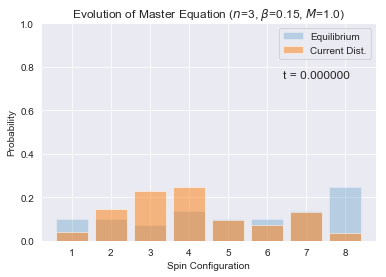

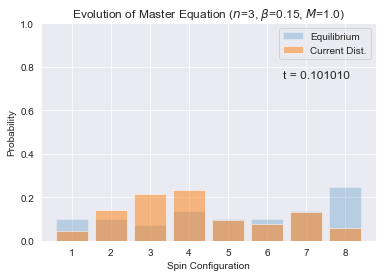

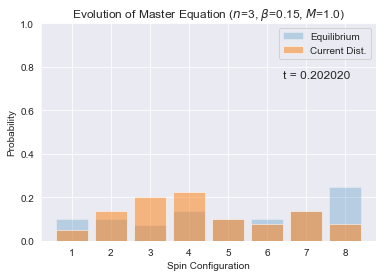

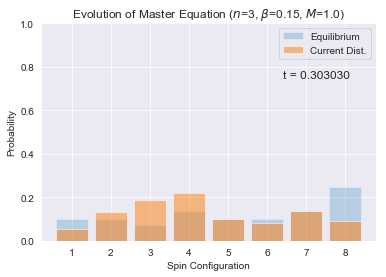

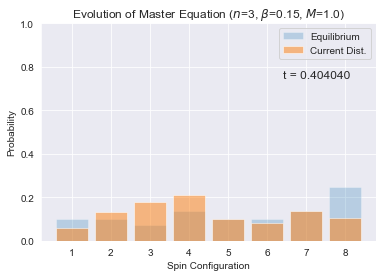

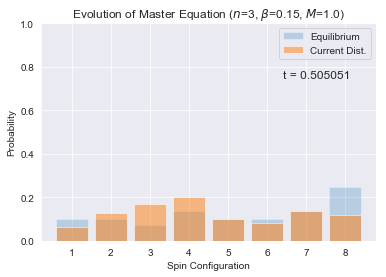

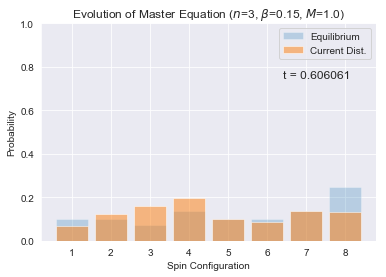

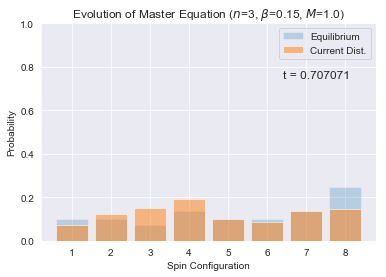

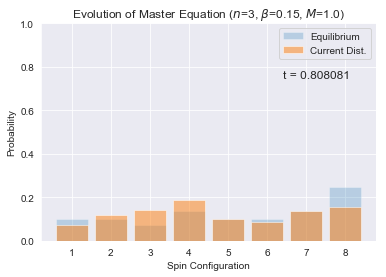

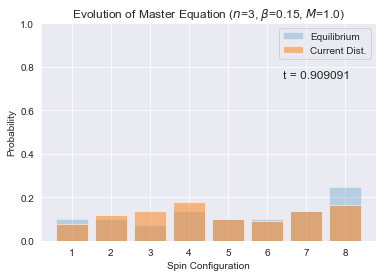

Done


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

print("Starting...")
for i in range(np.shape(p_array)[0])[0:10]:
    plt.bar(np.arange(len(p_array[0])),pi_vector,alpha=0.25,label='Equilibrium')
    plt.bar(np.arange(len(p_array[0])),p_array[i],alpha=0.5,label='Current Dist.')
    plt.xticks(np.arange(len(p_array[0])),np.arange(len(p_array[0]))+1)
    plt.annotate('t = {:f}'.format(t_array[i]),(5.4,0.75),size=12)
    plt.ylabel('Probability')
    plt.xlabel('Spin Configuration')
    plt.title('Evolution of Master Equation ($n$='+str(n)+r', $\beta$='+str(beta) +', $M$='+str(M)+')')
    fname = 'file_'+'{:04d}'.format(i)+'.png'
    plt.ylim((0.0,1.0))
    plt.legend()
#     plt.savefig('/Users/jakehanson/Desktop/Stochastic_Thermo/Code/gif_data/'+fname)
    plt.show()
print("Done")

### Now calculate EP using strengthened Landauer Bound and numerical method (3 faces)

### Get Entropy bounds for Wolpert paper (Benchmark) 

In [205]:
import itertools
spin_df = pd.DataFrame(spin_configs)


## Define Function to calculate entropy
def get_S(dist):
    S = 0
    for p_i in dist:
        if p_i != 0.:
            S = S - p_i*np.log2(p_i)
    return(S)

## Define Function to get the units in our autonomous spin model
def get_units(n):
    if n%2 != 0:
        print("ERROR - n must be even!")
        return(-1)
    else: 
        units = []
        for i in range(n-1):
            if i%2 == 0:
                units.append([i])
            else:
                units.append([i-1,i,i+1])
        units.append([n-2,n-1,0])
        return(units)

def I_Nstar(p_array,units,timestep):
    prob_dist = p_array[timestep]
    print("\nPROB DIST = ",prob_dist)
    n_units = len(units)
    
    ## First get entropy of global system
    S_tot = -1*get_S(prob_dist)
    print("Global Entropy Contribution = ",S_tot)
    
    ## Now do in-ex sum over units
    for k in range(1,n_units+1):
        if k % 2 == 0:
            sign = -1.
        else:
            sign = 1.
        print("k-wise intersections with k = ",k)
        for unit_list in itertools.combinations(units, k):
            intersection = list(set(unit_list[0]).intersection(*unit_list))
            size_of_int = len(intersection)
            int_configs = all_configs(size_of_int)  # gets possible values for intersection
            p_dist = []
                
            print("\tIntersection = ",list(set(unit_list[0]).intersection(*unit_list)))
            
            if size_of_int > 0:
                int_configs = all_configs(size_of_int)  # gets possible values for intersection
                p_dist = []
                ## Calculate entropy of marginal distribution
                for spin_config in int_configs:
                    index_list = []
                    ## get index where original array matches spin_config
                    for m in range(len(intersection)):
                        subsystem = intersection[m]
                        index_list.append(spin_df.index[spin_df[subsystem-1]==spin_config[m]].tolist())
                    final_indices = list(set(index_list[0]).intersection(*index_list))
    #                 print("\t\t Config Indices = ",final_indices)
                    p_dist.append(np.sum(np.asarray(prob_dist)[final_indices]))
                print("\t\tMarginal Dist = ",p_dist)
                print("\t\tEntropy Contribution = ",sign*get_S(p_dist))
                S_tot = S_tot + sign*get_S(p_dist)  # sum entropy contribution from intersection
            else:
                print("\t\tEmpty Intersection - Entropy Contribution = 0")

    return(S_tot)
        
    
p_array = [[1/2.,0,0,0,0,0,0,1/2.],[1/2.,0,1/2.,0,0,0,0,0]]
units = [[1,2],[2,3],[2]]
# units = [[1],[2],[3]]
print("\nI_star(t_0) = ", I_Nstar(p_array,units,0))
print("\nI_star(t_f) = ", I_Nstar(p_array,units,1))


PROB DIST =  [0.5, 0, 0, 0, 0, 0, 0, 0.5]
Global Entropy Contribution =  -1.0
k-wise intersections with k =  1
	Intersection =  [1, 2]
		Marginal Dist =  [0.5, 0.0, 0.0, 0.5]
		Entropy Contribution =  1.0
	Intersection =  [2, 3]
		Marginal Dist =  [0.5, 0.0, 0.0, 0.5]
		Entropy Contribution =  1.0
	Intersection =  [2]
		Marginal Dist =  [0.5, 0.5]
		Entropy Contribution =  1.0
k-wise intersections with k =  2
	Intersection =  [2]
		Marginal Dist =  [0.5, 0.5]
		Entropy Contribution =  -1.0
	Intersection =  [2]
		Marginal Dist =  [0.5, 0.5]
		Entropy Contribution =  -1.0
	Intersection =  [2]
		Marginal Dist =  [0.5, 0.5]
		Entropy Contribution =  -1.0
k-wise intersections with k =  3
	Intersection =  [2]
		Marginal Dist =  [0.5, 0.5]
		Entropy Contribution =  1.0

I_star(t_0) =  0.0

PROB DIST =  [0.5, 0, 0.5, 0, 0, 0, 0, 0]
Global Entropy Contribution =  -1.0
k-wise intersections with k =  1
	Intersection =  [1, 2]
		Marginal Dist =  [0.5, 0.5, 0.0, 0.0]
		Entropy Contribution =  1.0


In [207]:
get_units(8)

[[0], [0, 1, 2], [2], [2, 3, 4], [4], [4, 5, 6], [6], [6, 7, 0]]